In [34]:
import pathlib
import time
import datetime

import shapely.geometry
import networkx as nx
import opentnsim.core
import simpy

In [4]:
data_dir = pathlib.Path('~/data/vaarwegen').expanduser()
data_dir

PosixPath('/Users/baart_f/data/vaarwegen')

In [9]:
network_path = data_dir / 'export_full_network.yaml'

In [11]:
G = nx.read_yaml(network_path)

In [38]:
edge = list(G.edges())[0]
G.edges[edge]

{'Classification': 'CEMT',
 'Code': 'IV',
 'CoupledDepth': nan,
 'CoupledLength': nan,
 'CoupledWidth': nan,
 'Description': 'Rijn - Hernekanaalschip, Eenbaksduwstel',
 'Direction': 'H',
 'EndJunctionId': 8864523.0,
 'FairwayId': 1770.0,
 'FairwayNumber': nan,
 'ForeignCode': nan,
 'GeneralDepth': nan,
 'GeneralHeight': nan,
 'GeneralLength': nan,
 'GeneralWidth': nan,
 'GeoGeneration': 867,
 'GeoType': 'section',
 'Id_maximumdimensions': nan,
 'Id_navigability': 44833.0,
 'Length': 0.187,
 'MinimalDepthLowerLimit': nan,
 'MinimalDepthUpperLimit': nan,
 'Name': 'Vaarwegvak van 0 tot 0 - H',
 'Note': nan,
 'PushedDepth': nan,
 'PushedLength': nan,
 'PushedWidth': nan,
 'ReferenceLevel': nan,
 'RouteId': 55814,
 'RouteKmBegin': 0.0,
 'RouteKmEnd': 0.187,
 'SeaFairingDepth': nan,
 'SeaFairingHeight': nan,
 'SeaFairingLength': nan,
 'SeaFairingWidth': nan,
 'StartJunctionId': 8864358.0,
 'StatusCode': nan,
 'StatusDescription': nan,
 'TrajectCode': nan,
 'Type': nan,
 'TypeDescription': na

In [70]:
G.edges[edge]
a = G.nodes[edge[0]]
b = G.nodes[edge[1]]
a, b
a['geometry'] = shapely.geometry.Point(a['X'], a['Y'])
b['geometry'] = shapely.geometry.Point(b['X'], b['Y'])
a = G.nodes[edge[0]]
edge

(8864523.0, 8864358.0)

In [78]:
env = simpy.Environment()

In [79]:
simulation_start = datetime.datetime(2018, 7, 1)
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())
# Add graph to environment
env.FG = G

In [80]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": a['geometry'],  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)


# # Start the simulation
# env.process(start(env, vessel))
# env.run()

In [81]:
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Log, opentnsim.core.Locatable, opentnsim.core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": shapely.geometry.Point(a['X'], a['Y'])}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": shapely.geometry.Point(b['X'], b['Y'])}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)

nodes = [node_1, node_2]

In [82]:
path = [edge]


In [83]:
# # Add environment and path to the vessel
vessel.env = env
vessel.route = path[0]

vessel.route

(8864523.0, 8864358.0)

In [84]:
def start(env, vessel):
    vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
    yield from vessel.move()
    vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
env.process(start(env, vessel))
env.run()


In [85]:
vessel.log

{'Message': ['Start sailing',
  'Sailing from node 8864523.0 to node 8864358.0 start',
  'Sailing from node 8864523.0 to node 8864358.0 start',
  'Stop sailing'],
 'Timestamp': [datetime.datetime(2018, 7, 1, 0, 0),
  datetime.datetime(2018, 7, 1, 0, 0),
  datetime.datetime(2018, 7, 1, 0, 3, 6, 965317),
  datetime.datetime(2018, 7, 1, 0, 3, 6, 965317)],
 'Value': ['', 0, 0, ''],
 'Geometry': [<shapely.geometry.point.Point at 0x159db18b0>,
  <shapely.geometry.point.Point at 0x159db1910>]}

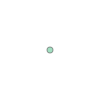

In [86]:
vessel.log["Geometry"][-1]